<a href="https://colab.research.google.com/github/craft-mini/ba_thesis_volatility_estimation/blob/main/BA_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyfolio
!pip install arch
!pip install scikit-optimize
!pip install PyPortfolioOpt
!pip install bt

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import pyfolio as pf
import plotly.express as px
import plotly.graph_objects as go
from arch import arch_model
import statsmodels.api as sm
import random
import datetime as dt
import requests
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection._search import BaseSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from pypfopt import risk_models, expected_returns, EfficientFrontier, objective_functions, plotting, DiscreteAllocation, get_latest_prices
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import bt

In [ ]:
# Define the tickers for each asset class
folio = ['SPY', 'DIA', 'QQQ','TLT', 'LQD', 'USO', 'GLD', 'SLV', 'EURUSD=X', 'USDJPY=X', 'GBPUSD=X', 'BTC-USD', 'ETH-USD']

# Association each ticker with its asset class
asset_classes = {
    'SPY': 'Stocks',
    'DIA': 'Stocks',
    'QQQ': 'Stocks',
    'TLT': 'Bonds',
    'LQD': 'Bonds',
    'USO': 'Commodities',
    'GLD': 'Commodities',
    'EURUSD=X': 'Currencies',
    'USDJPY=X': 'Currencies',
    'GBPUSD=X': 'Currencies',
    'BTC-USD':'Cryptocurrencies',
    'ETH-USD':'Cryptocurrencies'
}
'''These tickers have been informally selected to meet several criteria:
- reasonably liquid
- different performances and volatilities
- different amounts of data to test robustness
'''
folio_size = len(folio)

start_date = '2013-01-01'
end_date = '2023-12-31'

# Retrieve data for each asset class
stock_data = yf.download(folio, start=start_date, end=end_date)

# Take adj close prices
close_data = stock_data["Adj Close"]

# Store volume data
volume_data = stock_data['Volume']

In [ ]:
# Calculate daily logarithmic returns
log_ret_data = np.log(close_data.pct_change() + 1)[1:]

# Compute Monthly Volatility
#m_log_returns = log_ret_data.groupby(log_ret_data.index.strftime('%Y-%m')).sum()

# Compute Monthly Volatility
#m_log_returns.count()
#vol = log_ret_data.groupby(log_ret_data.index.strftime('%Y-%m')).std()*np.sqrt(12) # Realized Volatility

# Ensure the index is a DateTimeIndex
log_ret_data.index = pd.to_datetime(log_ret_data.index)

# Compute Rolling Volatility
vol = log_ret_data.rolling(window=21).std() # * np.sqrt(21)

# Compute Realized Volatility (Rolling)
realized_volatility = log_ret_data.rolling(window=21).std() * np.sqrt(252)


returns = log_ret_data.mean() * 252  # Annualized returns
annualized_volatility = log_ret_data.std() * np.sqrt(252)  # Annualized volatility

# Resample daily returns to monthly, aggregating with standard deviation
monthly_volatility = log_ret_data.resample('M').std()
annualized_monthly_volatility = monthly_volatility * np.sqrt(12)

In [ ]:
# Parkinson Volatility Estimator
# Extract high and low prices from your stock_data DataFrame
high_prices = stock_data['High']
low_prices = stock_data['Low']

# Calculate the natural logarithm of the ratio of high to low prices
log_hl_ratio = np.log(high_prices / low_prices)

# Apply the Parkinson's formula to estimate daily volatility
parkinson_volatility = np.sqrt((1 / (4 * np.log(2))) * (log_hl_ratio**2).mean())

# To annualize the Parkinson's volatility, multiply by the square root of the number of trading days
annualized_parkinson_volatility = parkinson_volatility * np.sqrt(252)

In [ ]:
'''
# Calculate logarithmic returns
log_ret_data = np.log(close_data.pct_change() + 1)

returns = log_ret_data.mean() * 252  # Annualized returns
annualized_volatility = log_ret_data.std() * np.sqrt(252)  # Annualized volatility

# Ensure the index is a DateTimeIndex
log_ret_data.index = pd.to_datetime(log_ret_data.index)
# Resample daily returns to monthly, aggregating with standard deviation
monthly_volatility = log_ret_data.resample('M').std()

# If you want to annualize the monthly volatility:
annualized_monthly_volatility = monthly_volatility * np.sqrt(12)

# Compute Rolling Volatility
vol = log_ret_data.rolling(window=21).std() * np.sqrt(21)
'''
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Initialize a DataFrame to store all features
features_df = pd.DataFrame(index=close_data.index)

# Calculate rolling volatility and SMAs for each ticker
for ticker in close_data.columns:
    # Rolling volatility
    features_df[f'vol_21_{ticker}'] = log_ret_data[ticker].rolling(window=21).std() * np.sqrt(21)
    features_df[f'vol_252_{ticker}'] = log_ret_data[ticker].rolling(window=252).std() * np.sqrt(252)

    # Lag features to align with forecasting nature
    features_df[f'vol_21_lag21_{ticker}'] = features_df[f'vol_21_{ticker}'].shift(21) #1
    features_df[f'vol_252_lag252_{ticker}'] = features_df[f'vol_252_{ticker}'].shift(252) #1

# Normalize volume data for each ticker and add as new features
#use volume for
for ticker in volume_data.columns:
    # Reshape volume data for scaler and normalize
    volume_scaled = scaler.fit_transform(volume_data[ticker].values.reshape(-1, 1))

    # Add normalized volume to features_df
    features_df[f'volume_norm_{ticker}'] = volume_scaled.flatten()  # Flatten back to 1D array after scaling

    # Optionally, create lagged volume features
    features_df[f'volume_norm_lag1_{ticker}'] = features_df[f'volume_norm_{ticker}'].shift(1)


features_df.fillna(0, inplace=True)
# features_df.fillna(method = 'bfill', inplace=True)
# features_df.fillna(method = 'ffill', inplace=True)  # Fill with 0 or method='ffill' for Forward fill
# Drop any rows with NaN values that may have resulted from shifting operations
#features_df.dropna(inplace=True)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9330.43
Distribution:                  Normal   AIC:                          -18654.9
Method:            Maximum Likelihood   BIC:                          -18637.1
                                        No. Observations:                 2746
Date:                Wed, Feb 07 2024   Df Residuals:                     2746
Time:                        18:30:09   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.3514e-06  3.901e-13  6.028e+06      0.000 [2.

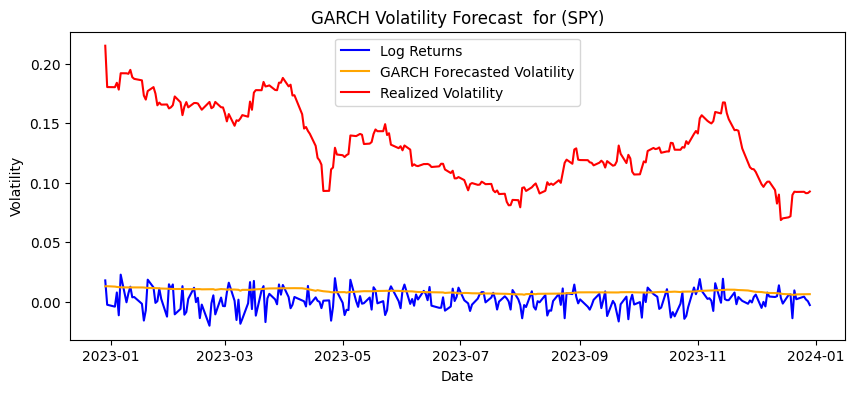



                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    DIA   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9460.64
Distribution:                  Normal   AIC:                          -18915.3
Method:            Maximum Likelihood   BIC:                          -18897.5
                                        No. Observations:                 2746
Date:                Wed, Feb 07 2024   Df Residuals:                     2746
Time:                        18:30:21   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.2271e-06  5.928e-13  3.757e+06      0.000 [

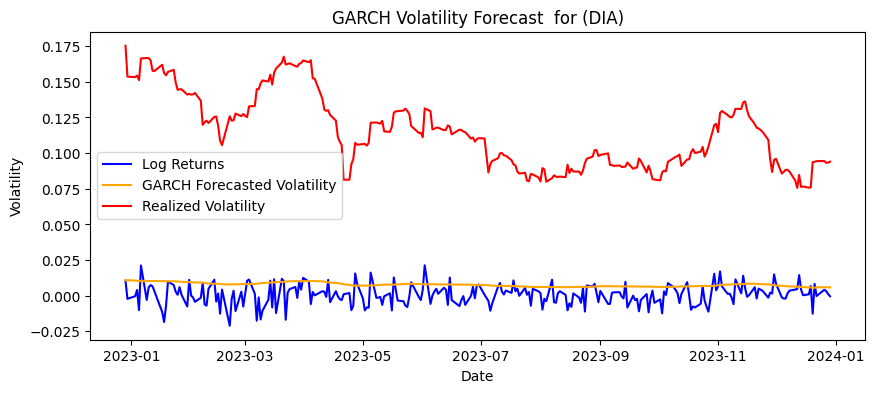

In [ ]:
# GARCH (1,1)

daily_returns = close_data.pct_change()
# GARCH(1,1) Model Improvement
garch_results = []

scale_factor=100

for index, ticker in enumerate(folio, start=0):
  test_size = 252
  rolling_predictions = []
  for i in range(test_size):
    train = vol[ticker][:-(test_size-i)].dropna() #features_df.filter(like=ticker, axis=1).dropna() #vol[ticker]#log_ret_data[ticker][:-(test_size-i)].dropna()
    garch_model = arch_model(train, mean='zero', vol="Garch", p=1, q=1 ,dist = 'normal', rescale=False)
    model_fit = garch_model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
  rolling_predictions = pd.Series(rolling_predictions, index=log_ret_data.index[-test_size:])

  print(model_fit)

  print('\n')
  plt.figure(figsize=(10,4))
  plt.plot(log_ret_data[ticker][-test_size:], label= "Log Returns", color='blue')
  plt.plot(rolling_predictions, label= "GARCH Forecasted Volatility", color='orange')
  plt.plot(realized_volatility[ticker][-test_size:], label= "Realized Volatility", color='red')
  plt.title(f'GARCH Volatility Forecast  for ({ticker})')
  plt.xlabel("Date")
  plt.ylabel("Volatility")
  plt.legend()
  plt.show()
  print('\n')

  # Calculate the metrics
  mae = mean_absolute_error(realized_volatility[ticker][-test_size:],rolling_predictions)
  mse = mean_squared_error(realized_volatility[ticker][-test_size:], rolling_predictions)
  rmse = np.sqrt(mse)
  over_estimation_error = (rolling_predictions - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
  under_estimation_error = (realized_volatility[ticker][-test_size:] - rolling_predictions).clip(lower=0).mean()
  over_estimated_periods = (rolling_predictions > realized_volatility[ticker][-test_size:]).mean() * 100
  over_under_estimation_time = (rolling_predictions - realized_volatility[ticker][-test_size:]).abs().mean()
  actual_returns = daily_returns[ticker][-test_size:]

  # Append results to the list
  garch_results.append({
     'ticker': ticker,
      'model': 'GARCH(1,1)',
      'mae' : mae,
      'rmse' : rmse,
      'mse': mse,
      'mean_over_estimation_error': over_estimation_error,
      'mean_under_estimation_error': under_estimation_error,
      'percent_periods_over_estimated': over_estimated_periods,
      'mean_time_over_under_estimation': over_under_estimation_time,
      'forecast_volatility': rolling_predictions.values,
      'actual_returns': actual_returns.values
  })

# Convert results to DataFrame
garch_df = pd.DataFrame(garch_results)


In [ ]:
garch_df

,ticker,model,mae,rmse,mse,mean_over_estimation_error,mean_under_estimation_error,percent_periods_over_estimated,mean_time_over_under_estimation,forecast_volatility,actual_returns
0,SPY,"GARCH(1,1)",0.123050,0.126522,0.016008,0.0,0.123050,0.0,0.123050,"[0.012862033727016034, 0.012970105304635167, 0...","[0.018000323254190986, -0.00263395272443101, -..."
1,DIA,"GARCH(1,1)",0.106486,0.109191,0.011923,0.0,0.106486,0.0,0.106486,"[0.010807800627912208, 0.010858984829485762, 0...","[0.010621919168537275, -0.0021984583497239862,..."


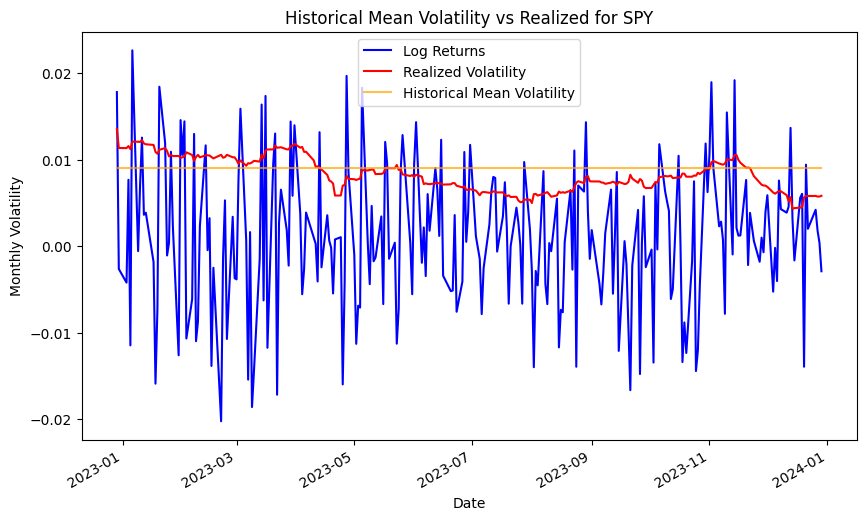

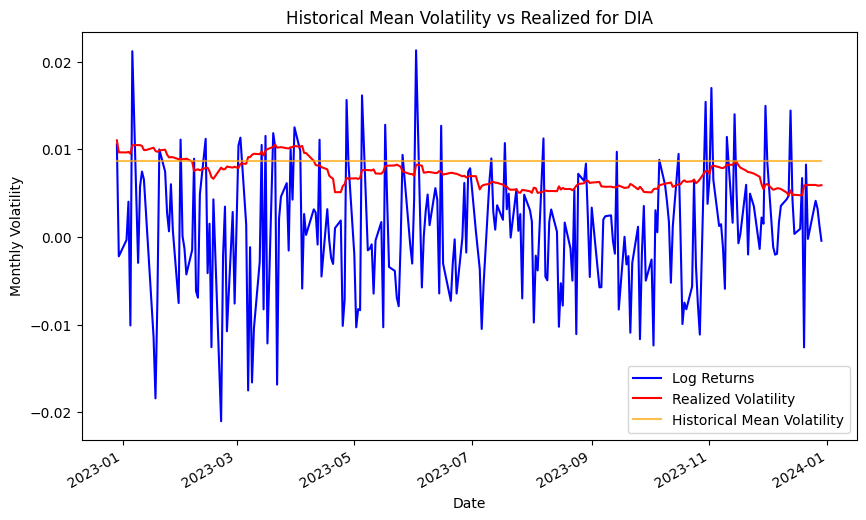

In [ ]:
# Historical Mean Model Implementation
historical_mean_results = []
monthly_volatility = vol
for ticker in folio:
    # Calculate the historical mean of monthly volatility
    historical_mean_volatility = monthly_volatility[ticker].mean()

    # Create a series of historical mean predictions
    historical_mean_predictions = pd.Series(historical_mean_volatility, index=monthly_volatility[ticker].index)

    # Calculate the metrics
    mae = mean_absolute_error(monthly_volatility[ticker][-test_size:], historical_mean_predictions[-test_size:])
    mse = mean_squared_error(monthly_volatility[ticker][-test_size:], historical_mean_predictions[-test_size:])
    rmse = np.sqrt(mse)
    r_squared = r2_score(monthly_volatility[ticker][-test_size:], historical_mean_predictions[-test_size:])
    over_estimation_error = (historical_mean_predictions[-test_size:] - monthly_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (monthly_volatility[ticker][-test_size:] - historical_mean_predictions[-test_size:]).clip(lower=0).mean()
    over_estimated_periods = (historical_mean_predictions[-test_size:] > monthly_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (historical_mean_predictions[-test_size:] - monthly_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    historical_mean_results.append({
        'ticker': ticker,
        'model': 'Historical Mean',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    plt.plot(log_ret_data[ticker][-test_size:], label= "Log Returns", color='blue')
    monthly_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    historical_mean_predictions[-test_size:].plot(label='Historical Mean Volatility', color='orange', alpha=0.7)
    plt.title(f'Historical Mean Volatility vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
historical_mean_df = pd.DataFrame(historical_mean_results)


In [ ]:
'''
# Random Walk Model Implementation
#realized vs monthly
random_walk_results = []

realized_volatility = vol
test_size = 12
for ticker in folio:
    # Random Walk prediction is simply the last observed value
    random_walk_predictions = realized_volatility[ticker].shift(1)

    # Ensure the indices are aligned for comparison
    aligned_realized_volatility = realized_volatility[ticker][-test_size+1:].reset_index(drop=True)
    aligned_predictions = random_walk_predictions[-test_size+1:].reset_index(drop=True)
    previous_realized_volatility = realized_volatility[ticker][-test_size:-1].reset_index(drop=True)

    # Calculate the metrics
    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], random_walk_predictions[-test_size:])
    mse = mean_squared_error(realized_volatility[ticker][-test_size:], random_walk_predictions[-test_size:])
    rmse = np.sqrt(mse)
    r_squared = r2_score(realized_volatility[ticker][-test_size:], random_walk_predictions[-test_size:])
    over_estimation_error = (random_walk_predictions[-test_size:] - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (realized_volatility[ticker][-test_size:] - random_walk_predictions[-test_size:]).clip(lower=0).mean()
    over_estimated_periods = (random_walk_predictions[-test_size:] > realized_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (random_walk_predictions[-test_size:] - realized_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    random_walk_results.append({
        'ticker': ticker,
        'model': 'Random Walk',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    m_log_returns[ticker][-test_size:].plot(label='Log Returns', color='blue')
    realized_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    random_walk_predictions[-test_size:].plot(label='Random Walk Volatility', color='orange', alpha=0.7)
    plt.title(f'Random Walk Volatility Forecast vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
random_walk_df = pd.DataFrame(random_walk_results)
'''

"\n# Random Walk Model Implementation\n#realized vs monthly\nrandom_walk_results = []\n\nrealized_volatility = vol\ntest_size = 12\nfor ticker in folio:\n    # Random Walk prediction is simply the last observed value\n    random_walk_predictions = realized_volatility[ticker].shift(1)\n\n    # Ensure the indices are aligned for comparison\n    aligned_realized_volatility = realized_volatility[ticker][-test_size+1:].reset_index(drop=True)\n    aligned_predictions = random_walk_predictions[-test_size+1:].reset_index(drop=True)\n    previous_realized_volatility = realized_volatility[ticker][-test_size:-1].reset_index(drop=True)\n\n    # Calculate the metrics\n    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], random_walk_predictions[-test_size:])\n    mse = mean_squared_error(realized_volatility[ticker][-test_size:], random_walk_predictions[-test_size:])\n    rmse = np.sqrt(mse)\n    r_squared = r2_score(realized_volatility[ticker][-test_size:], random_walk_predictions

In [ ]:
#random_walk_df

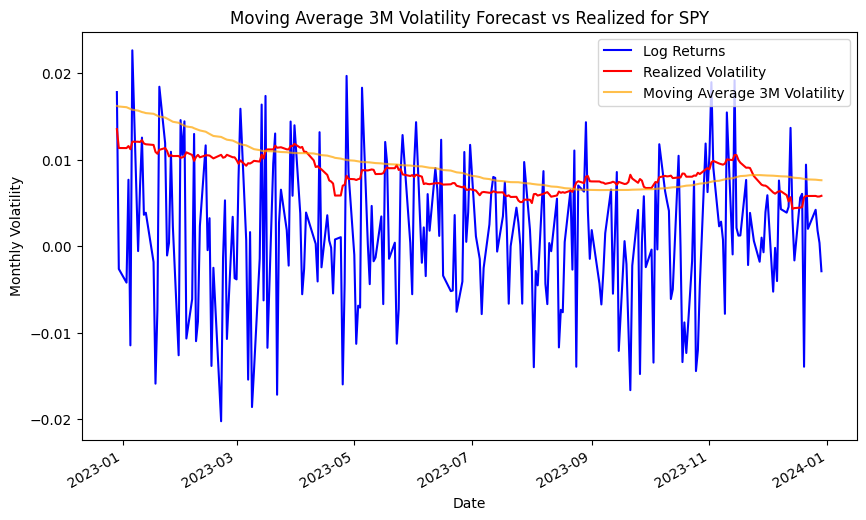

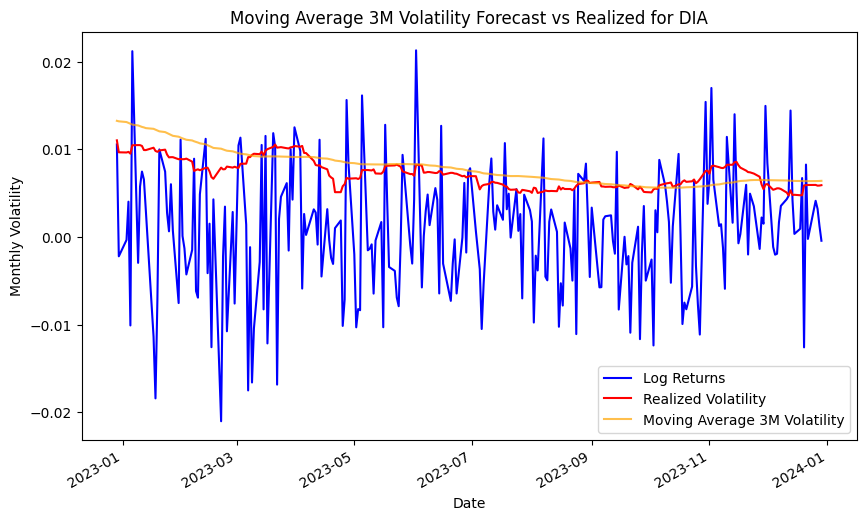

In [ ]:
# 3M Moving Average Model Implementation
moving_average_3m_results = []

realized_volatility = vol

for ticker in folio:
    # Ensure ticker is in the data
    if ticker not in log_ret_data.columns:
        continue

    # Calculate the 3M moving average of realized volatility
    moving_average_3m = realized_volatility[ticker].rolling(window=63).mean()  # Approx. 3M for monthly data

    # Calculate the metrics
    mse = mean_squared_error(realized_volatility[ticker][-test_size:], moving_average_3m[-test_size:])
    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], moving_average_3m[-test_size:])
    rmse = np.sqrt(mse)
    r_squared = r2_score(realized_volatility[ticker][-test_size:], moving_average_3m[-test_size:])
    over_estimation_error = (moving_average_3m[-test_size:] - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (realized_volatility[ticker][-test_size:] - moving_average_3m[-test_size:]).clip(lower=0).mean()
    over_estimated_periods = (moving_average_3m[-test_size:] > realized_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (moving_average_3m[-test_size:] - realized_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    moving_average_3m_results.append({
        'ticker': ticker,
        'model': '3M Moving Average',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    log_ret_data[ticker][-test_size:].plot(label='Log Returns', color='blue')
    realized_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    moving_average_3m[-test_size:].plot(label='Moving Average 3M Volatility', color='orange', alpha=0.7)
    plt.title(f'Moving Average 3M Volatility Forecast vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
moving_average_3m_df = pd.DataFrame(moving_average_3m_results)


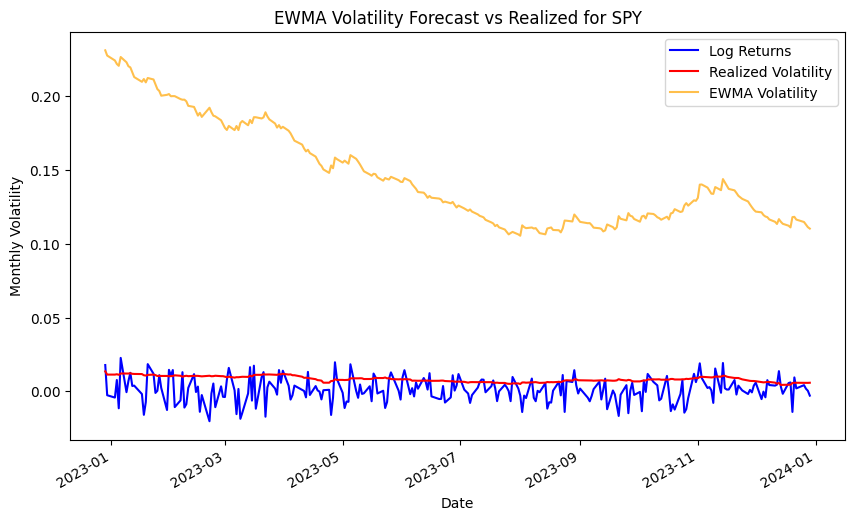

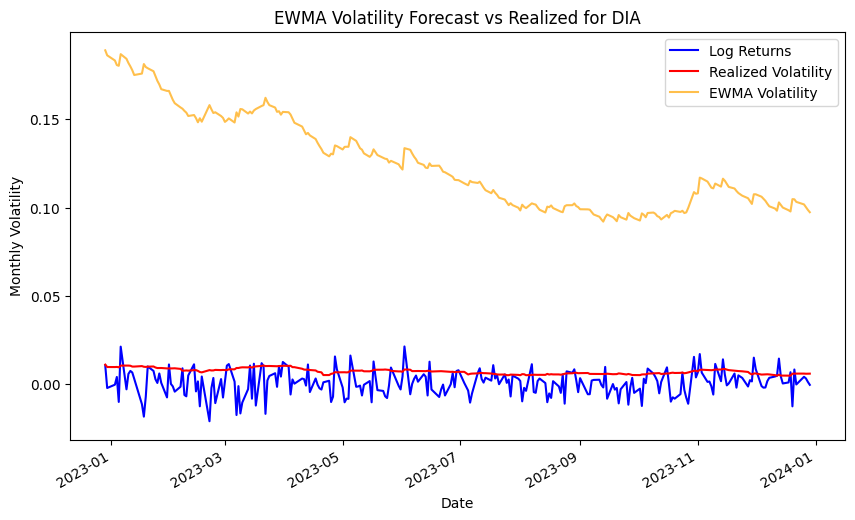

In [ ]:
# EWMA Model Implementation with Additional Metrics
ewma_results = []

realized_volatility = vol

for ticker in folio:
    # Ensure ticker is in the data
    if ticker not in log_ret_data.columns:
        continue

    # Calculate the EWMA of realized volatility
    ewma_volatility = log_ret_data[ticker].ewm(span=63).std() * np.sqrt(252)

    # Calculate the metrics
    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], ewma_volatility[-test_size:])
    mse = mean_squared_error(realized_volatility[ticker][-test_size:], ewma_volatility[-test_size:])
    rmse = np.sqrt(mse)
    r_squared = r2_score(realized_volatility[ticker][-test_size:], ewma_volatility[-test_size:])
    over_estimation_error = (ewma_volatility[-test_size:] - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (realized_volatility[ticker][-test_size:] - ewma_volatility[-test_size:]).clip(lower=0).mean()
    #over_estimated_periods = (ewma_volatility[-test_size:] > realized_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (ewma_volatility[-test_size:] - realized_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    ewma_results.append({
        'ticker': ticker,
        'model': 'EWMA',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    log_ret_data[ticker][-test_size:].plot(label='Log Returns', color='blue')
    realized_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    ewma_volatility[-test_size:].plot(label='EWMA Volatility', color='orange', alpha=0.7)
    plt.title(f'EWMA Volatility Forecast vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
ewma_df = pd.DataFrame(ewma_results)


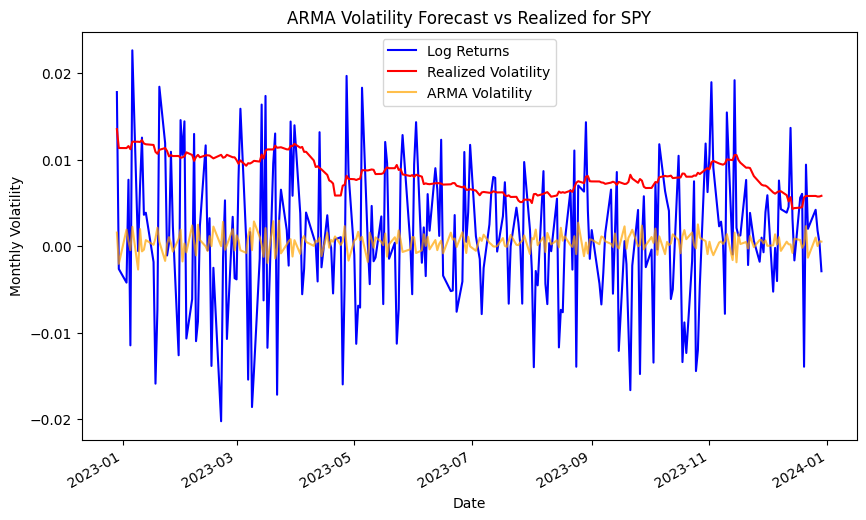

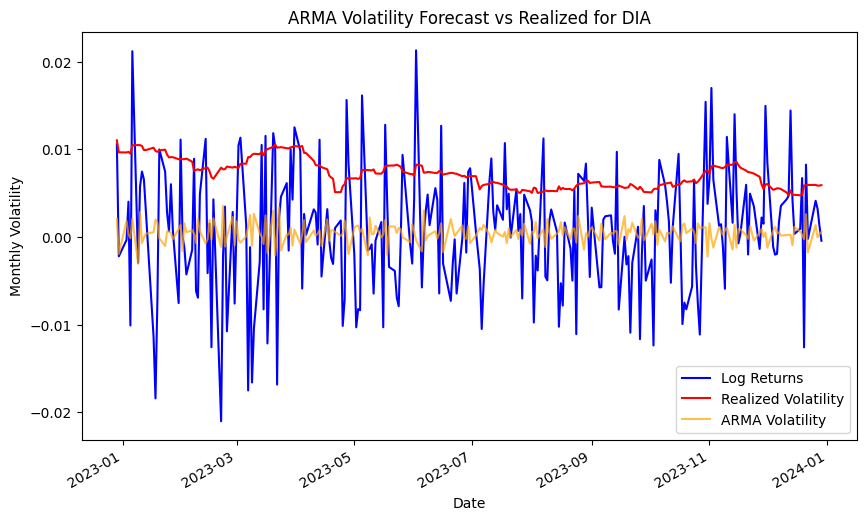

In [ ]:
# ARMA Model Implementation
arma_results = []

realized_volatility = vol
test_size = 252
for ticker in folio:
    # Ensure ticker is in the data
    if ticker not in log_ret_data.columns:
        continue

    # Prepare the data
    arma_data = log_ret_data[ticker].dropna()

    # Define and fit the ARMA model (using ARIMA with d=0 for ARMA)
    arma_model = sm.tsa.ARIMA(arma_data, order=(2, 0, 2)).fit()

    # Predict the last 'test_size' points for comparison
    arma_predictions = arma_model.predict(start=len(arma_data)-test_size, end=len(arma_data)-1)

    # Calculate the metrics
    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], arma_predictions)
    mse = mean_squared_error(realized_volatility[ticker][-test_size:], arma_predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(realized_volatility[ticker][-test_size:], arma_predictions)
    over_estimation_error = (arma_predictions[-test_size:] - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (realized_volatility[ticker][-test_size:] - arma_predictions[-test_size:]).clip(lower=0).mean()
    #over_estimated_periods = (arma_predictions[-test_size:] > realized_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (arma_predictions[-test_size:] - realized_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    arma_results.append({
        'ticker': ticker,
        'model': 'ARMA',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    log_ret_data[ticker][-test_size:].plot(label='Log Returns', color='blue')
    realized_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    arma_predictions[-test_size:].plot(label='ARMA Volatility', color='orange', alpha=0.7)
    plt.title(f'ARMA Volatility Forecast vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
arma_df = pd.DataFrame(arma_results)


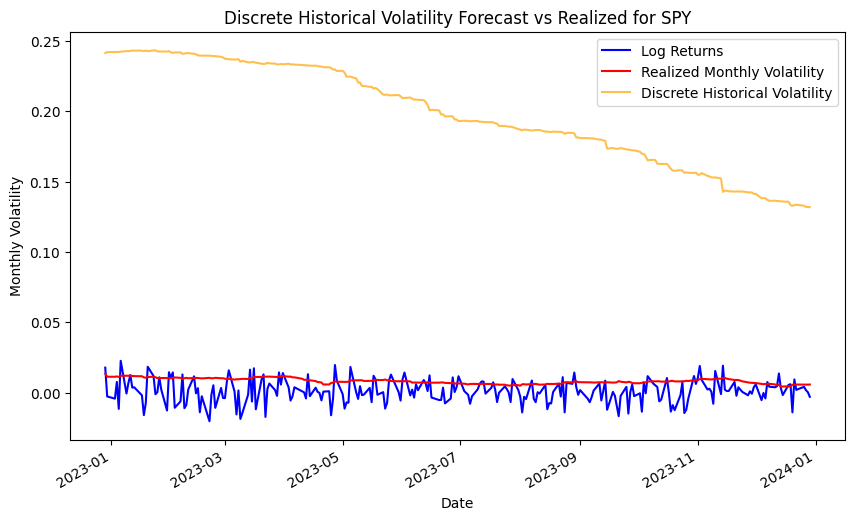

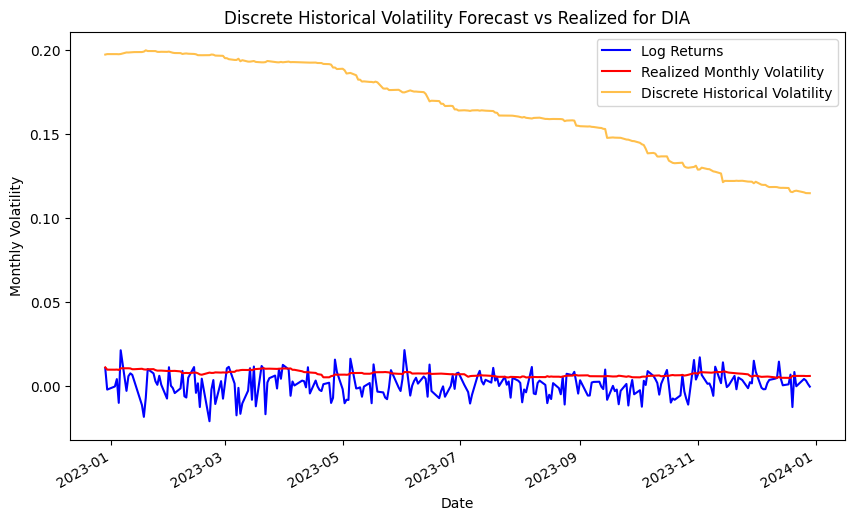

In [ ]:
# Discrete Historical Simulation Model Implementation
dhs_results = []

realized_volatility = vol
test_size = 252
for ticker in folio:
    # Ensure ticker is in the data
    if ticker not in log_ret_data.columns:
        continue

    # Calculate historical volatility as the standard deviation of log returns
    # Here, we use a rolling window equivalent to 1 year (252 trading days) for DHS
    dhs_volatility = log_ret_data[ticker].rolling(window=252).std() * np.sqrt(252)

    # For DHS, the forecast is simply the most recent historical volatility
    dhs_forecast = dhs_volatility.shift(1)  # Shift by 1 to simulate forecasting

    # Calculate the metrics for the last 'test_size' observations
    mae = mean_absolute_error(realized_volatility[ticker][-test_size:], dhs_forecast[-test_size:])
    mse = mean_squared_error(realized_volatility[ticker][-test_size:], dhs_forecast[-test_size:])
    rmse = np.sqrt(mse)
    r_squared = r2_score(realized_volatility[ticker][-test_size:], dhs_forecast[-test_size:])
    over_estimation_error = (dhs_forecast[-test_size:] - realized_volatility[ticker][-test_size:]).clip(lower=0).mean()
    under_estimation_error = (realized_volatility[ticker][-test_size:] - dhs_forecast[-test_size:]).clip(lower=0).mean()
    #over_estimated_periods = (dhs_forecast[-test_size:] > realized_volatility[ticker][-test_size:]).mean() * 100
    over_under_estimation_time = (dhs_forecast[-test_size:] - realized_volatility[ticker][-test_size:]).abs().mean()

    # Append results to the list
    dhs_results.append({
        'ticker': ticker,
        'model': 'Discrete Historical',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time
    })

    # Visualization for each ticker
    plt.figure(figsize=(10, 6))
    log_ret_data[ticker][-test_size:].plot(label='Log Returns', color='blue')
    realized_volatility[ticker][-test_size:].plot(label='Realized Monthly Volatility', color='red')
    dhs_forecast[-test_size:].plot(label='Discrete Historical Volatility', color='orange', alpha=0.7)
    plt.title(f'Discrete Historical Volatility Forecast vs Realized for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Volatility')
    plt.legend()
    plt.show()
    print('\n')

# Convert results to DataFrame
dhs_df = pd.DataFrame(dhs_results)


In [ ]:
dhs_df

,ticker,model,mae,mse,rmse,r_squared,mean_over_estimation_error,mean_under_estimation_error,percent_periods_over_estimated,mean_time_over_under_estimation
0,SPY,Discrete Historical,0.189126,0.036949,0.192222,-9661.606295,0.189126,0.0,75.0,0.189126
1,DIA,Discrete Historical,0.158014,0.025666,0.160205,-9994.179340,0.158014,0.0,75.0,0.158014


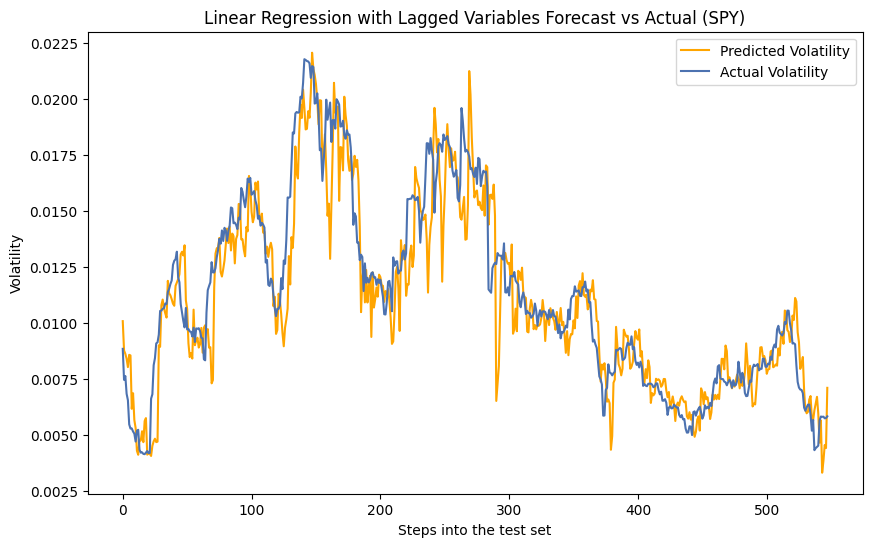

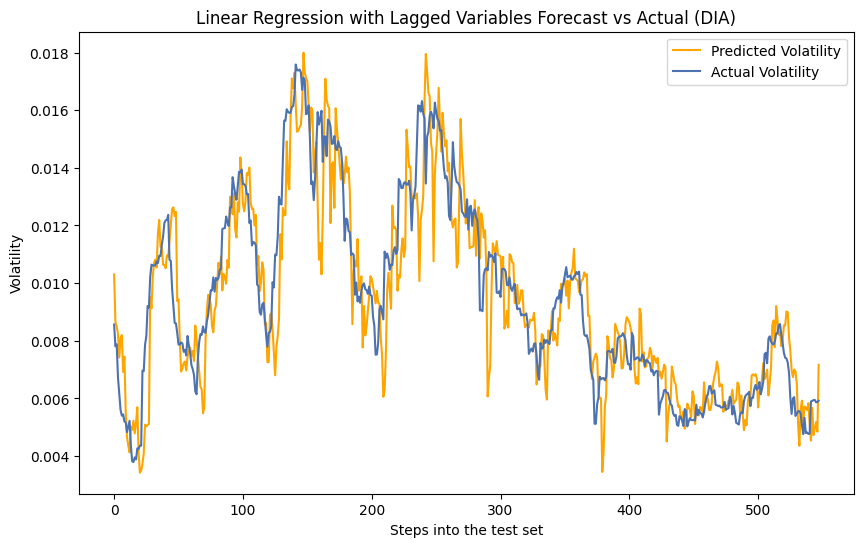

In [ ]:
# Improved Linear Regression
# List to store results for each ticker
results_linear_regression = []

# Number of lagged variables to consider
num_lags = 5  # You can adjust this based on your preference

# Loop through tickers
for ticker in folio:
    # Extract close prices and calculate log returns
    X = pd.DataFrame(vol[ticker].dropna())

    # Create lagged variables
    for lag in range(1, num_lags + 1):
        X[f'Lag_{lag}'] = X.iloc[:,0].shift(lag)

    # Drop rows with NaN values resulting from creating lagged variables
    X.dropna(inplace=True)

    # Set up the feature matrix and target variable
    features = X.iloc[:,1:].copy()
    target = X.iloc[:,0].shift(-num_lags)

    # Drop rows with NaN values resulting from shifting the target variable
    features.dropna(inplace=True)
    target.dropna(inplace=True)

    # Ensure both arrays have the same length
    min_length = min(len(features), len(target))
    features = features[:min_length]
    target = target[:min_length]

    # Create Train test split
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20,
                                                                                random_state=12345, shuffle=False)


    # Fit model
    my_lm = LinearRegression()
    my_lm.fit(features_train, target_train)

    # Make predictions on training and test sets
    train_fcst = my_lm.predict(features_train)
    test_fcst = my_lm.predict(features_test)

    # Calculate metrics
    mae = mean_absolute_error(target_test, test_fcst)
    mse = mean_squared_error(target_test, test_fcst)
    rmse = np.sqrt(mse)
    r_squared = r2_score(target_test, test_fcst)
    over_estimation_error = (test_fcst - target_test).clip(lower=0).mean()
    under_estimation_error = (target_test - test_fcst).clip(lower=0).mean()
    over_estimated_periods = (test_fcst > target_test).mean() * 100
    over_under_estimation_time = (test_fcst - target_test).abs().mean()
    train_r2 = r2_score(target_train, train_fcst)
    test_r2 = r2_score(target_test, test_fcst)

    # Plot the result
    plt.figure(figsize=(10, 6))
    #m_log_returns[ticker][-test_size:].plot(label='Log Returns', color='blue')
    #realized_volatility[ticker][-test_size:].plot(label='Realized Volatility', color='red')
    plt.plot(test_fcst, label="Predicted Volatility", color='orange')
    plt.plot(target_test.values, label="Actual Volatility")
    plt.xlabel('Steps into the test set')
    plt.ylabel('Volatility')
    plt.title(f"Linear Regression with Lagged Variables Forecast vs Actual ({ticker})")
    plt.legend()
    plt.show()
    print('\n')

    # Store results
    results_linear_regression.append({
        'ticker': ticker,
        'model': 'Linear Regression',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_fcst': test_fcst,
        'target_test': target_test.values
    })

    # Convert results to DataFrame for easier integration into comprehensive comparison
    linear_regression_df = pd.DataFrame(results_linear_regression)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 2198, number of used features: 1
[LightGBM] [Info] Start training from score 0.008466


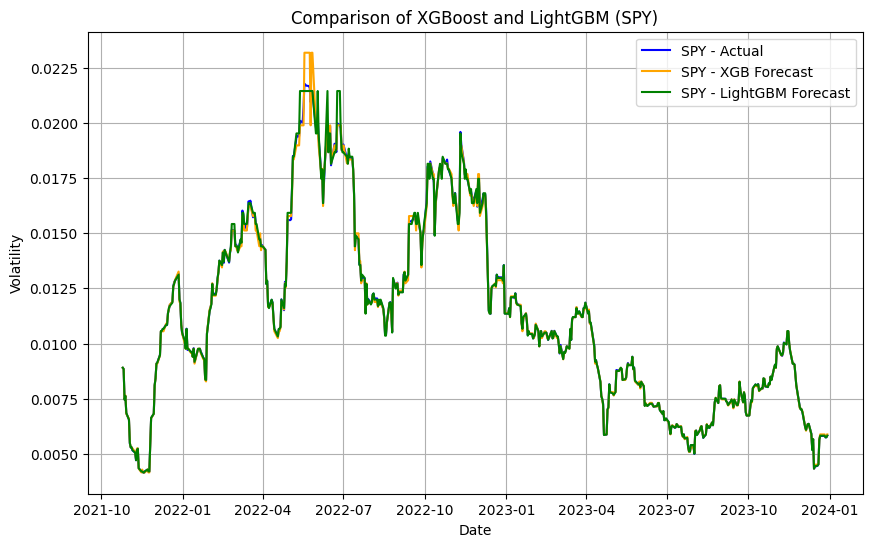



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 2198, number of used features: 1
[LightGBM] [Info] Start training from score 0.008494


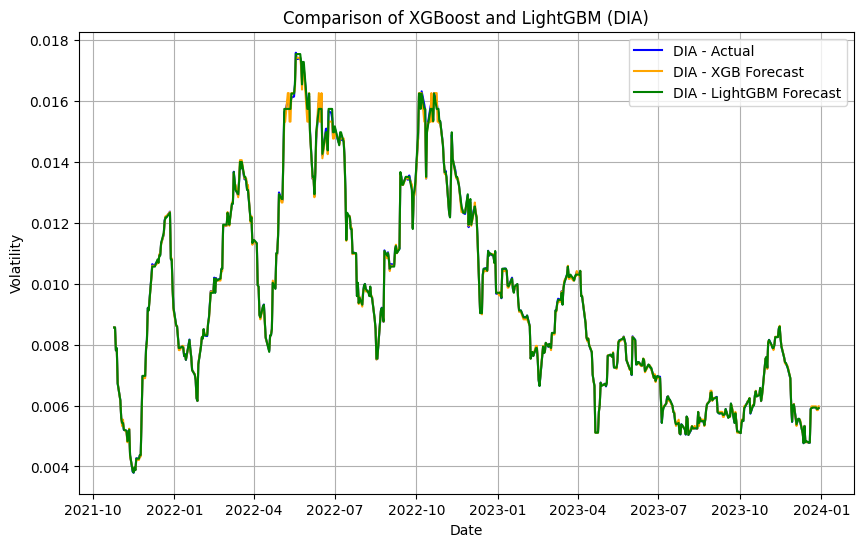

In [ ]:
# Gradient Boosting with XGBoost and LigthGBM

# Dynamic test size based on a percentage of the dataset
test_size_percentage = 0.2
min_test_size = 0.2  # Minimum number of observations in the test set

# List to store results for each ticker
results_xgb = []
results_lgbm = []

for ticker in folio:
  data = pd.DataFrame(vol[ticker])
  data = data.dropna()

  # Applying the default XGBoost model
  # Create objects X and y
  X = data #features_df.filter(like=ticker, axis=1)
  y = vol[ticker] #data[ticker]

  # Align X and y to ensure they have the same index and drop any rows with NaN values in either
  X, y = X.align(y, join='inner', axis=0)

  # Dynamically set test size
  test_size = max(int(len(X) * test_size_percentage), min_test_size)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state = 42, shuffle=False)
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=12345, shuffle=False)

  # XGBoost
  my_xgb = XGBRegressor()
  my_xgb.fit(X_train, y_train)

  # Make predictions on training and test sets
  train_fcst = my_xgb.predict(X_train)
  test_fcst = my_xgb.predict(X_test)
  xgb_fcst = test_fcst

  # Calculate metrics
  mae = mean_absolute_error(y_test, test_fcst)
  mse = mean_squared_error(y_test, test_fcst)
  rmse = np.sqrt(mse)
  r_squared = r2_score(y_test, test_fcst)
  over_estimation_error = (y_test - test_fcst).clip(lower=0).mean()
  under_estimation_error = (test_fcst - y_test).clip(lower=0).mean()
  over_estimated_periods = (y_test > test_fcst).mean() * 100
  over_under_estimation_time = (y_test - test_fcst).abs().mean()
  train_r2 = r2_score(y_train, train_fcst)
  test_r2 = r2_score(y_test, test_fcst)


  results_xgb.append({
        'ticker': ticker,
        'model': 'XGBoost',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_fcst': test_fcst,
        'target_test': y_test.values,
    })

  # LightGBM
  my_lgbm = LGBMRegressor()
  my_lgbm.fit(X_train, y_train)

  # Make predictions on training and test sets
  train_fcst = my_lgbm.predict(X_train)
  test_fcst = my_lgbm.predict(X_test)
  lgbm_fcst = test_fcst

  # Calculate additional metrics for LightGBM
  mae = mean_absolute_error(y_test, test_fcst)
  mse = mean_squared_error(y_test, test_fcst)
  rmse = np.sqrt(mse)
  r_squared = r2_score(y_test, test_fcst)
  over_estimation_error = (y_test - test_fcst).clip(lower=0).mean()
  under_estimation_error = (test_fcst - y_test).clip(lower=0).mean()
  over_estimated_periods = (y_test > test_fcst).mean() * 100
  over_under_estimation_time = (y_test - test_fcst).abs().mean()
  train_r2 = r2_score(y_train, train_fcst)
  test_r2 = r2_score(y_test, test_fcst)

  results_lgbm.append({
        'ticker': ticker,
        'model': 'LightGBM',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_fcst': test_fcst,
        'target_test': y_test.values,
    })

  # Create a graph to compare the XGBoost and LightGBM forecast to the actuals
  plt.figure(figsize=(10,6))
  plt.plot(y_test.index, list(y_test), label=f"{ticker} - Actual", color = 'blue')
  plt.plot(y_test.index, list(xgb_fcst), label=f"{ticker} - XGB Forecast", color = 'orange')
  plt.plot(y_test.index, list(lgbm_fcst), label=f"{ticker} - LightGBM Forecast", color = 'green')
  plt.ylabel('Volatility')
  plt.xlabel('Date')
  plt.title(f"Comparison of XGBoost and LightGBM ({ticker})")
  plt.legend()
  plt.grid(True)
  plt.show()
  print('\n')

# Convert the lists of dictionaries to DataFrames
results_xgb_df = pd.DataFrame(results_xgb)
results_lgbm_df = pd.DataFrame(results_lgbm)

# Add a 'model' column to distinguish between XGBoost and LightGBM results
xgb_df = results_xgb_df
lgbm_df = results_lgbm_df

Epoch 1/100
13/13 [==============================] - 6s 152ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/100
13/13 [==============================] - 1s 72ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/100
13/13 [==============================] - 1s 80ms/step - loss: 8.0892e-04 - mean_squared_error: 8.0892e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/100
13/13 [==============================] - 1s 73ms/step - loss: 6.4395e-04 - mean_squared_error: 6.4395e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/100
13/13 [==============================] - 1s 70ms/step - loss: 5.4292e-04 - mean_squared_error: 5.4292e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/100
13/13 [==============================] - 1s 71ms/step - loss: 4.1762e-04 - mean_squared_error: 4.1762e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.

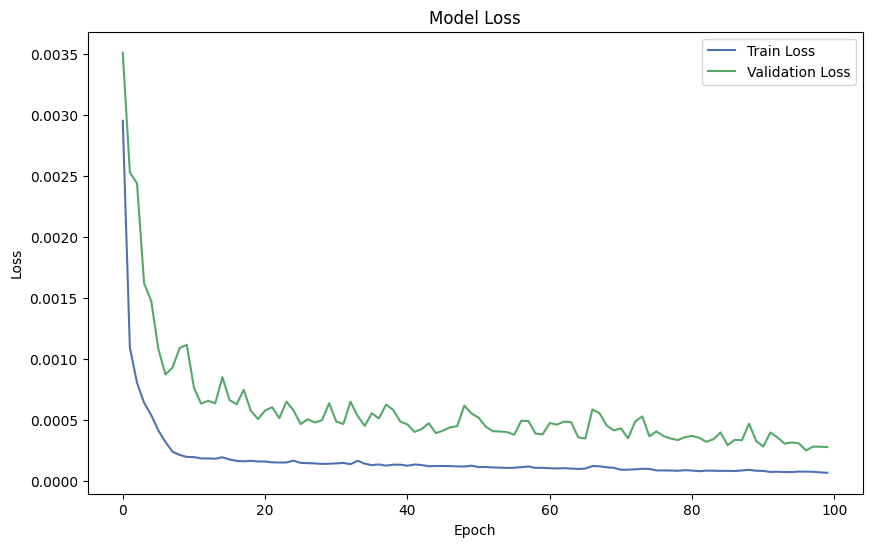

13/13 [==============================] - 1s 18ms/step
Epoch 1/100
27/27 [==============================] - 8s 141ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.0040e-04 - val_mean_squared_error: 8.0040e-04
Epoch 3/100
27/27 [==============================] - 2s 64ms/step - loss: 6.3880e-04 - mean_squared_error: 6.3880e-04 - val_loss: 5.8462e-04 - val_mean_squared_error: 5.8462e-04
Epoch 4/100
27/27 [==============================] - 2s 68ms/step - loss: 4.6152e-04 - mean_squared_error: 4.6152e-04 - val_loss: 5.3852e-04 - val_mean_squared_error: 5.3852e-04
Epoch 5/100
27/27 [==============================] - 2s 67ms/step - loss: 3.8870e-04 - mean_squared_error: 3.8870e-04 - val_loss: 5.2270e-04 - val_mean_squared_error: 5.2270e-04
Epoch 6/100
27/27 [==============================] - 2s 78ms/step - loss: 3.635

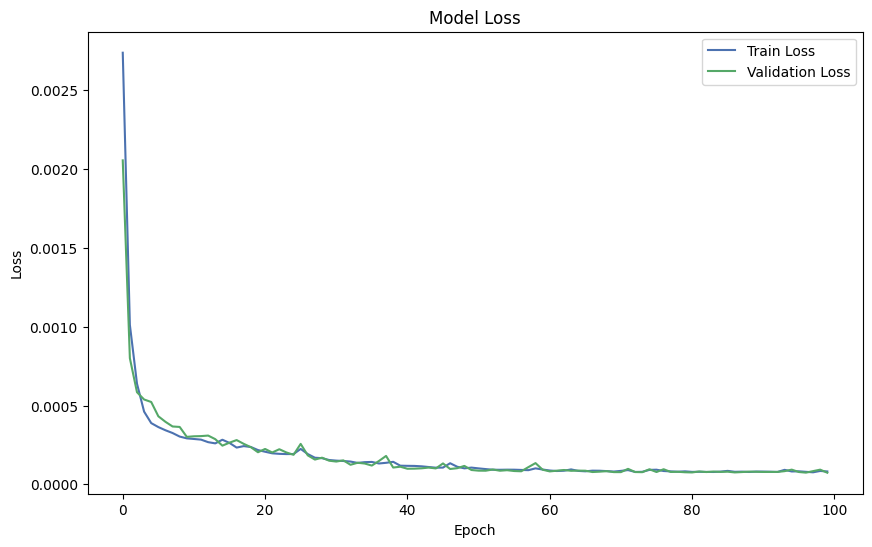

13/13 [==============================] - 1s 17ms/step
Epoch 1/100
42/42 [==============================] - 8s 84ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 2/100
42/42 [==============================] - 3s 65ms/step - loss: 5.3396e-04 - mean_squared_error: 5.3396e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 3/100
42/42 [==============================] - 4s 91ms/step - loss: 3.5676e-04 - mean_squared_error: 3.5676e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/100
42/42 [==============================] - 3s 63ms/step - loss: 3.1206e-04 - mean_squared_error: 3.1206e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/100
42/42 [==============================] - 3s 66ms/step - loss: 2.8088e-04 - mean_squared_error: 2.8088e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/100
42/42 [==============================] - 3s 64ms/step - loss: 2.8392e-04 - mean_squared_erro

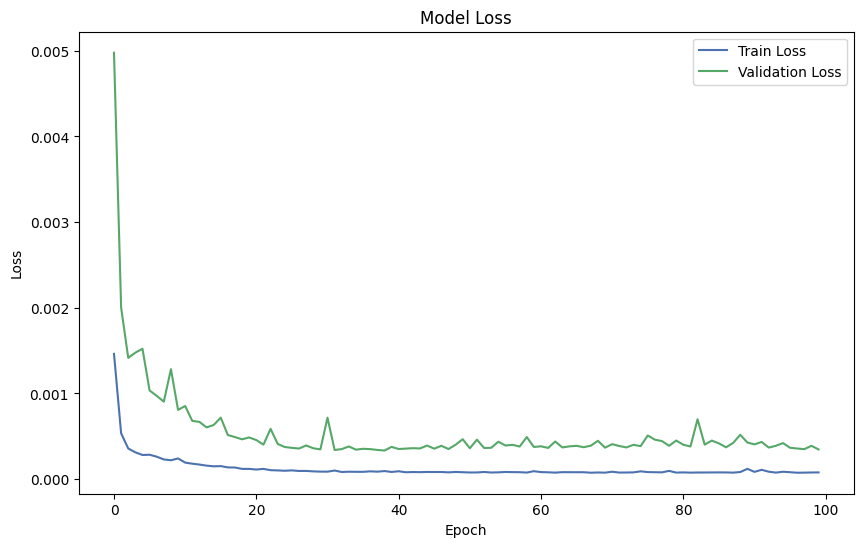

13/13 [==============================] - 1s 19ms/step
Epoch 1/100
56/56 [==============================] - 9s 80ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 7.2414e-04 - val_mean_squared_error: 7.2414e-04
Epoch 2/100
56/56 [==============================] - 4s 74ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 5.3629e-04 - val_mean_squared_error: 5.3629e-04
Epoch 3/100
56/56 [==============================] - 4s 75ms/step - loss: 7.9198e-04 - mean_squared_error: 7.9198e-04 - val_loss: 4.1989e-04 - val_mean_squared_error: 4.1989e-04
Epoch 4/100
56/56 [==============================] - 4s 64ms/step - loss: 6.8809e-04 - mean_squared_error: 6.8809e-04 - val_loss: 6.0201e-04 - val_mean_squared_error: 6.0201e-04
Epoch 5/100
56/56 [==============================] - 4s 64ms/step - loss: 6.9080e-04 - mean_squared_error: 6.9080e-04 - val_loss: 4.1129e-04 - val_mean_squared_error: 4.1129e-04
Epoch 6/100
56/56 [==============================] - 5s 83ms/step - loss

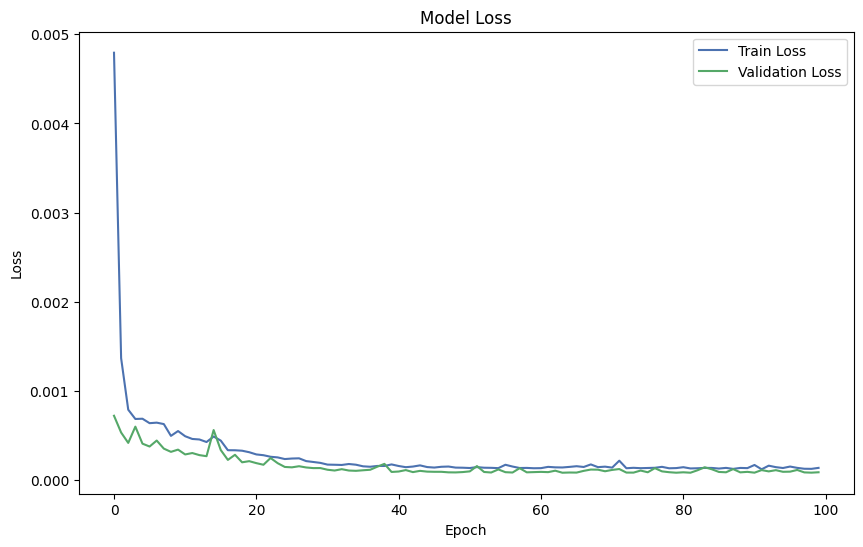

13/13 [==============================] - 1s 18ms/step
Epoch 1/100
70/70 [==============================] - 10s 95ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 6.6789e-04 - val_mean_squared_error: 6.6789e-04
Epoch 2/100
70/70 [==============================] - 4s 62ms/step - loss: 8.7911e-04 - mean_squared_error: 8.7911e-04 - val_loss: 5.7596e-04 - val_mean_squared_error: 5.7596e-04
Epoch 3/100
70/70 [==============================] - 5s 69ms/step - loss: 6.0588e-04 - mean_squared_error: 6.0588e-04 - val_loss: 3.3623e-04 - val_mean_squared_error: 3.3623e-04
Epoch 4/100
70/70 [==============================] - 5s 68ms/step - loss: 5.5352e-04 - mean_squared_error: 5.5352e-04 - val_loss: 3.2337e-04 - val_mean_squared_error: 3.2337e-04
Epoch 5/100
70/70 [==============================] - 4s 61ms/step - loss: 5.6640e-04 - mean_squared_error: 5.6640e-04 - val_loss: 3.4212e-04 - val_mean_squared_error: 3.4212e-04
Epoch 6/100
70/70 [==============================] - 5s 76ms/st

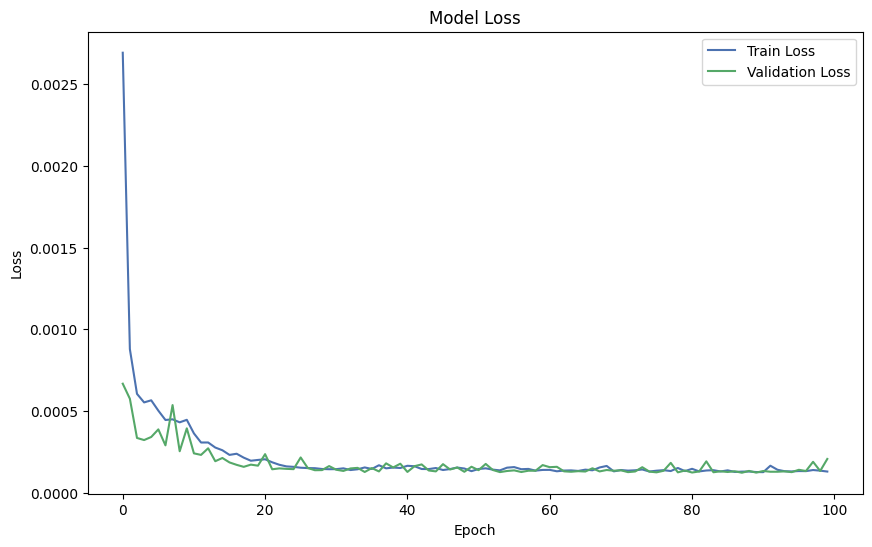

13/13 [==============================] - 1s 19ms/step
Epoch 1/100
13/13 [==============================] - 6s 161ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/100
13/13 [==============================] - 1s 88ms/step - loss: 7.6242e-04 - mean_squared_error: 7.6242e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/100
13/13 [==============================] - 1s 97ms/step - loss: 5.9432e-04 - mean_squared_error: 5.9432e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/100
13/13 [==============================] - 1s 90ms/step - loss: 4.7987e-04 - mean_squared_error: 4.7987e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/100
13/13 [==============================] - 1s 81ms/step - loss: 3.9873e-04 - mean_squared_error: 3.9873e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/100
13/13 [==============================] - 1s 88ms/step - loss: 2.7594e-04 - mean_squared_err

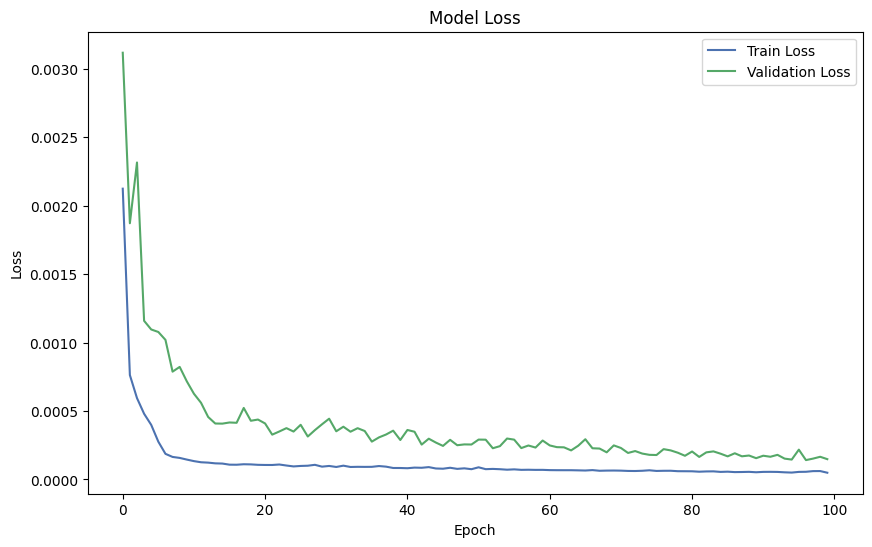

13/13 [==============================] - 1s 29ms/step
Epoch 1/100
27/27 [==============================] - 7s 103ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/100
27/27 [==============================] - 2s 72ms/step - loss: 8.0693e-04 - mean_squared_error: 8.0693e-04 - val_loss: 8.0906e-04 - val_mean_squared_error: 8.0906e-04
Epoch 3/100
27/27 [==============================] - 2s 87ms/step - loss: 5.6173e-04 - mean_squared_error: 5.6173e-04 - val_loss: 6.3933e-04 - val_mean_squared_error: 6.3933e-04
Epoch 4/100
27/27 [==============================] - 2s 91ms/step - loss: 3.7202e-04 - mean_squared_error: 3.7202e-04 - val_loss: 5.9873e-04 - val_mean_squared_error: 5.9873e-04
Epoch 5/100
27/27 [==============================] - 2s 72ms/step - loss: 3.0865e-04 - mean_squared_error: 3.0865e-04 - val_loss: 4.2228e-04 - val_mean_squared_error: 4.2228e-04
Epoch 6/100
27/27 [==============================] - 2s 69ms/step - los

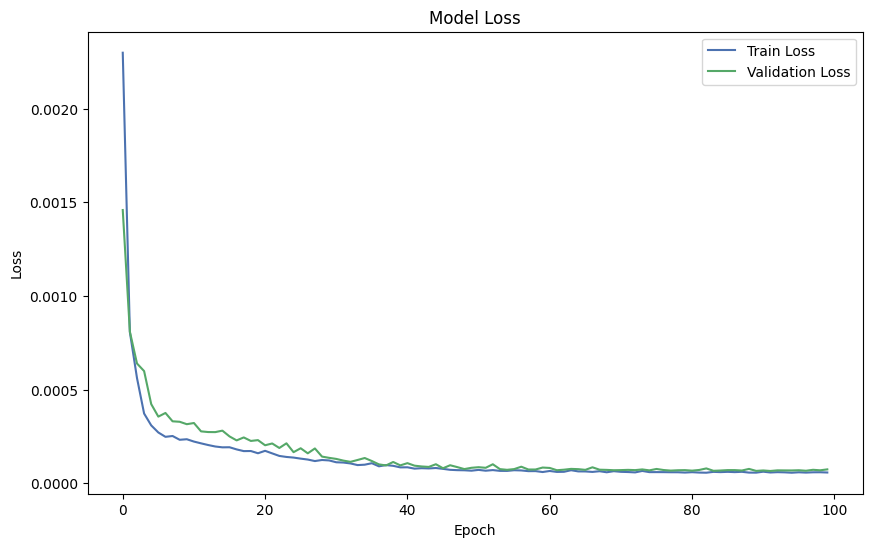

13/13 [==============================] - 1s 20ms/step
Epoch 1/100
42/42 [==============================] - 8s 87ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/100
42/42 [==============================] - 3s 68ms/step - loss: 6.1201e-04 - mean_squared_error: 6.1201e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/100
42/42 [==============================] - 3s 78ms/step - loss: 3.7014e-04 - mean_squared_error: 3.7014e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/100
42/42 [==============================] - 3s 78ms/step - loss: 2.9313e-04 - mean_squared_error: 2.9313e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/100
42/42 [==============================] - 3s 67ms/step - loss: 2.5580e-04 - mean_squared_error: 2.5580e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/100
42/42 [==============================] - 3s 70ms/step - loss: 2.4419e-04 - mean_squared_erro

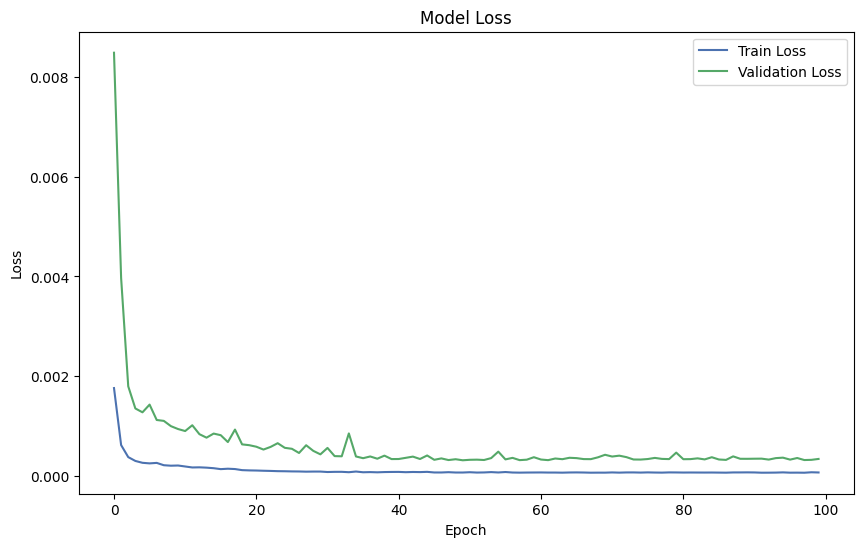

13/13 [==============================] - 2s 22ms/step
Epoch 1/100
56/56 [==============================] - 9s 87ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 5.2797e-04 - val_mean_squared_error: 5.2797e-04
Epoch 2/100
56/56 [==============================] - 5s 88ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.2161e-04 - val_mean_squared_error: 3.2161e-04
Epoch 3/100
56/56 [==============================] - 4s 73ms/step - loss: 6.9483e-04 - mean_squared_error: 6.9483e-04 - val_loss: 2.5816e-04 - val_mean_squared_error: 2.5816e-04
Epoch 4/100
56/56 [==============================] - 4s 69ms/step - loss: 5.6501e-04 - mean_squared_error: 5.6501e-04 - val_loss: 3.0229e-04 - val_mean_squared_error: 3.0229e-04
Epoch 5/100
56/56 [==============================] - 5s 87ms/step - loss: 5.3563e-04 - mean_squared_error: 5.3563e-04 - val_loss: 2.2768e-04 - val_mean_squared_error: 2.2768e-04
Epoch 6/100
56/56 [==============================] - 4s 69ms/step - loss

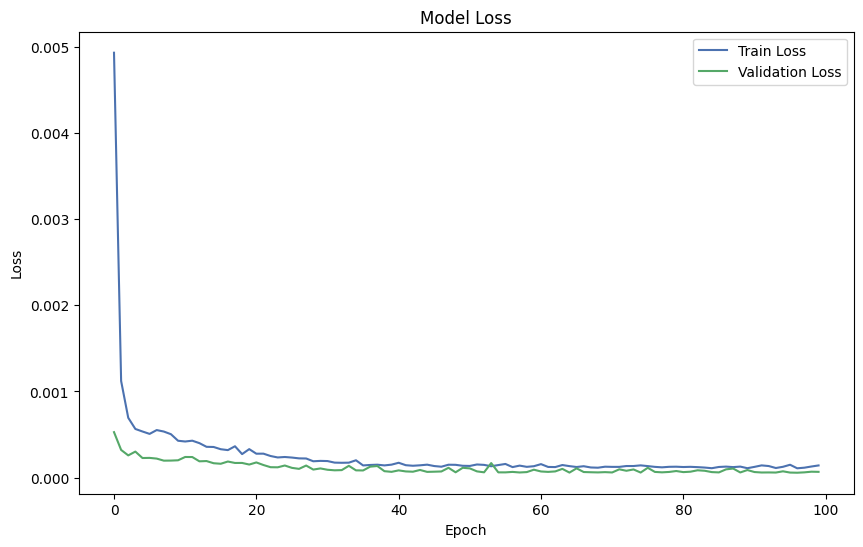

13/13 [==============================] - 1s 20ms/step
Epoch 1/100
70/70 [==============================] - 10s 95ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 4.3806e-04 - val_mean_squared_error: 4.3806e-04
Epoch 2/100
70/70 [==============================] - 5s 69ms/step - loss: 9.0279e-04 - mean_squared_error: 9.0279e-04 - val_loss: 2.0114e-04 - val_mean_squared_error: 2.0114e-04
Epoch 3/100
70/70 [==============================] - 6s 88ms/step - loss: 6.6514e-04 - mean_squared_error: 6.6514e-04 - val_loss: 1.9707e-04 - val_mean_squared_error: 1.9707e-04
Epoch 4/100
70/70 [==============================] - 5s 69ms/step - loss: 6.5630e-04 - mean_squared_error: 6.5630e-04 - val_loss: 2.1639e-04 - val_mean_squared_error: 2.1639e-04
Epoch 5/100
70/70 [==============================] - 5s 68ms/step - loss: 4.9788e-04 - mean_squared_error: 4.9788e-04 - val_loss: 1.7468e-04 - val_mean_squared_error: 1.7468e-04
Epoch 6/100
70/70 [==============================] - 6s 82ms/st

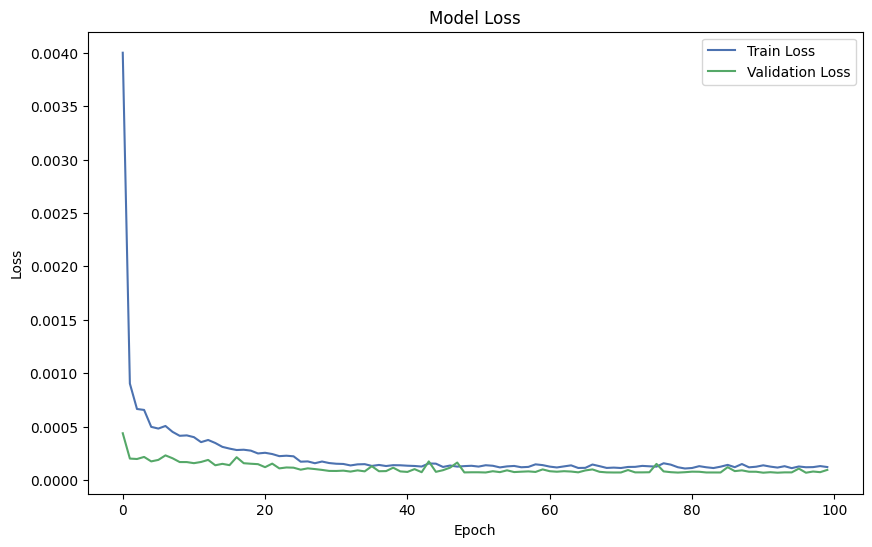

13/13 [==============================] - 1s 19ms/step
mae                                4.684950e-04
mse                                6.140632e-07
rmse                               7.487736e-04
r_squared                          9.678762e-01
mean_over_estimation_error         1.438743e-05
mean_under_estimation_error        1.480077e-05
percent_periods_over_estimated     5.063752e+01
mean_time_over_under_estimation    2.918820e-05
test_r2                            9.997519e-01
dtype: float64


In [ ]:
#LSTM 3.0

# Function to create sequences
def create_sequences(data, n_lags=60):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Define the number of splits for TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_results = []


for ticker in folio:
  data = vol[ticker].dropna()

  # Normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
  for train_index, test_index in tscv.split(scaled_data):
    X_train, X_test = scaled_data[train_index], scaled_data[test_index]
    y_train, y_test = scaled_data[train_index], scaled_data[test_index]

    X_train, y_train = create_sequences(X_train)
    X_test, y_test = create_sequences(X_test)

    # Define the LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(units=50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))#, callbacks=[early_stopping])

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Predict and inverse transform to original scale
    predicted_volatility = model.predict(X_test)
    predicted_volatility = scaler.inverse_transform(predicted_volatility)
    actual_volatility = scaler.inverse_transform(y_test.reshape(-1, 1))

    # plt.figure(figsize=(10, 6))
    # plt.plot(data.index, actual_volatility, label='Actual Volatility', color='blue')
    # plt.plot(data.index, predicted_volatility, label='Predicted Volatility',color='orange', alpha=0.7)
    # plt.title(f'Actual vs. Predicted Volatility for {ticker}')
    # plt.xlabel('Date')
    # plt.ylabel('Volatility')
    # plt.legend()
    # plt.show()

    # Calculate metrics
    mae = mean_absolute_error(actual_volatility, predicted_volatility)
    mse = mean_squared_error(actual_volatility, predicted_volatility)
    rmse = np.sqrt(mse)
    r_squared = r2_score(actual_volatility, predicted_volatility)

    lstm_results.append({
      'ticker': ticker,
      'model': 'LSTM',
      'mae': mae,
      'mse': mse,
      'rmse': rmse,
      'r_squared': r_squared,
      'mean_over_estimation_error': over_estimation_error,
      'mean_under_estimation_error': under_estimation_error,
      'percent_periods_over_estimated': over_estimated_periods,
      'mean_time_over_under_estimation': over_under_estimation_time,
      #'train_r2': train_r2,
      'test_r2': test_r2,
      'test_fcst': test_fcst,
      #'target_test': y.values,
    })

# Convert results to DataFrame and print average metrics
lstm_df = pd.DataFrame(lstm_results)

In [ ]:
# Sequential Hybrid Model Linear Regression + LSTM
hybrid_lstm_results = []

# Here, using a 21-day rolling window for volatility calculation
y_volatility = log_ret_data.rolling(window=21).std().shift(-1) * np.sqrt(21)  # Shift(-1) for next day prediction

for ticker in close_data.columns:
  # Initial Model: Linear Regression
  # Prepare target variable 'y' for the ticker
  y = vol[ticker].shift(-1).dropna() #y_volatility.dropna()

  # Assuming 'features_df' already contains engineered features for this ticker
  X = features_df.filter(like=ticker, axis=1).dropna()

  # # Align X and y to ensure they have the same index and drop any rows with NaN values in either
  X, y = X.align(y, join='inner', axis=0) # y = y.reindex(X.index)
  X.dropna(inplace=True)
  y.dropna(inplace=True)  # Ensure y does not contain NaN values

  # Check and handle NaN values explicitly
  if X.isnull().values.any() or y.isnull().values.any():
      print(f"NaN values detected in data for ticker {ticker}. Cleaning data...")
      X.dropna(inplace=True)
      y = y.reindex(X.index).dropna()  # Reindex y to X's index and drop NaNs

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Ensure no NaN values in y_train and y_test
  assert not y_train.isnull().values.any(), "NaN values found in y_train"
  assert not y_test.isnull().values.any(), "NaN values found in y_test"

  # Linear Regression as the first model
  lr_model = LinearRegression()
  lr_model.fit(X_train, y_train)
  lr_predictions = lr_model.predict(X_test)

  # Prepare data for LSTM (reshape X_test based on your LSTM input requirement)
  X_lstm = np.reshape(lr_predictions, (lr_predictions.shape[0], 1, 1))
  y_lstm = y_test.values.reshape(-1, 1)

  # Define and train LSTM model
  lstm_model = Sequential()
  lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
  lstm_model.add(LSTM(units=50))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mean_squared_error')
  lstm_model.fit(X_lstm, y_lstm, epochs=20, batch_size=1, verbose=0) #verbose=2

  # Make predictions
  final_predictions = lstm_model.predict(X_lstm)

  test_fcst = final_predictions
  y_test = y_lstm

  # Calculate metrics
  mae = mean_absolute_error(y_lstm, final_predictions)
  mse = mean_squared_error(y_lstm, final_predictions)
  rmse = np.sqrt(mse)
  r_squared = r2_score(y_lstm, final_predictions)
  #over_estimation_error = (y_lstm - final_predictions).clip(lower=0).mean()
  #under_estimation_error = (final_predictions - y_lstm).clip(lower=0).mean()
  over_estimated_periods = (y_lstm > final_predictions).mean() * 100
  #over_under_estimation_time = (y_lstm - final_predictions).abs().mean()
  #train_r2 = r2_score(y_train, train_fcst)
  test_r2 = r2_score(y_lstm, final_predictions)

  # Store results
  hybrid_lstm_results.append({'ticker': ticker,
      'model': 'Hybrid LSTM',
      'mae': mae,
      'mse': mse,
      'rmse': rmse,
      'r_squared': r_squared,
      'mean_over_estimation_error': over_estimation_error,
      'mean_under_estimation_error': under_estimation_error,
      'percent_periods_over_estimated': over_estimated_periods,
      'mean_time_over_under_estimation': over_under_estimation_time,
      #'train_r2': train_r2,
      'test_r2': test_r2,
      'test_fcst': test_fcst,
      #'target_test': y_test.values,
  })

  # Convert the list of results to a DataFrame
  hybrid_lstm_df = pd.DataFrame(hybrid_lstm_results)

In [ ]:
# Random Forest

# Random Forest Model List
random_forest_results = []

# Using a 21-day rolling window for volatility calculation
y_volatility = log_ret_data.rolling(window=21).std().shift(-1) * np.sqrt(21)  # Adjusted to annualize volatility

for ticker in close_data.columns:
    # Prepare target variable 'y' for the ticker
    y = y_volatility[ticker].dropna()

    # Assuming 'features_df' already contains engineered features for this ticker
    X = features_df.filter(like=ticker, axis=1).dropna()

    # Align X and y to ensure they have the same index
    X, y = X.align(y, join='inner', axis=0)
    X.dropna(inplace=True)
    y.dropna(inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    train_fcst = rf_model.predict(X_train)
    rf_predictions = rf_model.predict(X_test)
    test_fcst = rf_predictions

    # Evaluate the model
    mae = mean_absolute_error(y_test, test_fcst)
    mse = mean_squared_error(y_test, test_fcst)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, test_fcst)
    over_estimation_error = (y_test - test_fcst).clip(lower=0).mean()
    under_estimation_error = (test_fcst - y_test).clip(lower=0).mean()
    over_estimated_periods = (y_test > test_fcst).mean() * 100
    over_under_estimation_time = (y_test - test_fcst).abs().mean()
    train_r2 = r2_score(y_train, train_fcst)
    test_r2 = r2_score(y_test, test_fcst)

    # Store results for each ticker
    random_forest_results.append({
        'ticker': ticker,
        'model': 'Random Forest',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_fcst': test_fcst,
        'target_test': y_test.values,
    })

# Convert the list of results to a DataFrame
random_forest_df = pd.DataFrame(random_forest_results)

In [ ]:
# Random Forest + LSTM

# Using a 21-day rolling window for volatility calculation
y_volatility = log_ret_data.rolling(window=21).std().shift(-1) * np.sqrt(21)  # Adjusted to annualize volatility

hybrid_rf_lstm_results = []

for ticker in close_data.columns:
    # Prepare target variable 'y' for the ticker
    y = vol[ticker].dropna()#y_volatility[ticker].dropna()

    # Assuming 'features_df' already contains engineered features for this ticker
    X = features_df.filter(like=ticker, axis=1).dropna()

    # Align X and y to ensure they have the same index
    X, y = X.align(y, join='inner', axis=0)
    X.dropna(inplace=True)
    y.dropna(inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest for feature selection or initial prediction
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    # Normalize RF predictions for LSTM input
    scaler = MinMaxScaler()
    rf_predictions_scaled = scaler.fit_transform(rf_predictions.reshape(-1, 1))

    # Reshape for LSTM input
    X_lstm = np.reshape(rf_predictions_scaled, (rf_predictions_scaled.shape[0], 1, 1))
    y_lstm = y_test.values.reshape(-1, 1)

    # Define LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train LSTM model
    lstm_model.fit(X_lstm, y_lstm, epochs=20, batch_size=1, verbose=2)

    # Make final predictions
    final_predictions = lstm_model.predict(X_lstm)
    final_predictions = scaler.inverse_transform(final_predictions)  # Inverse transform to original scale
    test_fcst = final_predictions
    y_test = y_lstm

    # Calculate metrics
    mae = mean_absolute_error(y_lstm, final_predictions)
    mse = mean_squared_error(y_lstm, final_predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_lstm, final_predictions)
    #over_estimation_error = (y_lstm - final_predictions).clip(lower=0).mean()
    #under_estimation_error = (final_predictions - y_lstm).clip(lower=0).mean()
    over_estimated_periods = (y_lstm > final_predictions).mean() * 100
    #over_under_estimation_time = (y_lstm - final_predictions).abs().mean()
    #train_r2 = r2_score(y_train, train_fcst)
    test_r2 = r2_score(y_lstm, final_predictions)

    # Store results for each ticker
    hybrid_rf_lstm_results.append({
        'ticker': ticker,
        'model': 'Hybrid RF + LSTM',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'mean_over_estimation_error': over_estimation_error,
        'mean_under_estimation_error': under_estimation_error,
        'percent_periods_over_estimated': over_estimated_periods,
        'mean_time_over_under_estimation': over_under_estimation_time,
        #'train_r2': train_r2,
        'test_r2': test_r2,
        'test_fcst': test_fcst,
        #'target_test': y_test.values,
    })

# Convert the list of results to a DataFrame
hybrid_rf_lstm_df = pd.DataFrame(hybrid_rf_lstm_results)

In [ ]:
# Simplified models dictionary.
models = {
    'Random Forest': rf_model,
    'Hybrid RF + LSTM': hybrid_rf_lstm_model,
    'GARCH': garch_model,
    'Historical Mean': historical_mean_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'LSTM': simple_lstm_model,
    'Hybrid Linear Regression + LSTM': hybrid_lstm_model,
}


def plot_feature_importance(model, feature_names, model_name, ticker):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name} on {ticker}')
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_actual, y_pred, model_name, ticker):
    residuals = y_actual - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residuals for {model_name} on {ticker}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()

# Assuming features_df contains feature names
feature_names = features_df.columns
plot_feature_importance(rf_model, feature_names, 'Random Forest', 'SPY')

for ticker in folio:
    # Check if the ticker's data is available in X_test and y_test
    if ticker not in X_test or ticker not in y_test:
        print(f"Data for ticker {ticker} not found in X_test or y_test. Skipping...")
        continue
    # Assuming X_test and y_test are dictionaries or similar structures where you can access data by ticker
    X_test_ticker = X_test[ticker]
    y_test_ticker = y_test[ticker]

    for model_name, model in models.items():
        # Generate predictions. Adjust this part if some models require different handling
        y_pred = model.predict(X_test_ticker)

        # Ensure y_pred and y_test_ticker are numpy arrays for consistency in plotting functions
        y_pred = np.array(y_pred)
        y_actual = np.array(y_test_ticker)

        # Plot Feature Importance for models that support it
        if hasattr(model, 'feature_importances_'):
            feature_names = X_test_ticker.columns
            plot_feature_importance(model, feature_names, model_name, ticker)

        # Plot Residuals
        plot_residuals(y_actual, y_pred, model_name, ticker)

In [ ]:
# Combine all model results into a single DataFrame
all_model_results = pd.concat([garch_df, historical_mean_df, moving_average_3m_df, arma_df, linear_regression_df, xgb_df, lgbm_df, lstm_df, hybrid_lstm_df, random_forest_df, hybrid_rf_lstm_df], ignore_index=True) # ewma_df, dhs_df

# Pivot the DataFrame for easier comparison
pivot_model_results = all_model_results.pivot_table(index='ticker', columns='model', values=['mse', 'mae', 'rmse', 'r_squared'])

# Display the pivoted DataFrame
print(pivot_model_results.head())

# Heatmap for MSE across all models and tickers
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_model_results['mse'], annot=True, cmap='coolwarm', fmt=".4f")
plt.title('MSE Comparison Across Models and Tickers')
plt.ylabel('Ticker')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n')

# Heatmap for MAE across all models and tickers
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_model_results['mae'], annot=True, cmap='coolwarm', fmt=".4f")
plt.title('MAE Comparison Across Models and Tickers')
plt.ylabel('Ticker')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n')
'''
# Heatmap for r_squared across all models and tickers
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_model_results['r_squared'], annot=True, cmap='coolwarm', fmt=".4f")
plt.title('R_Squared Comparison Across Models and Tickers')
plt.ylabel('Ticker')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''

In [ ]:
all_model_results['asset_class'] = all_model_results['ticker'].map(asset_classes)

# Group by asset class and model, then calculate mean of performance metrics
asset_class_performance = all_model_results.groupby(['asset_class', 'model']).mean().reset_index()

# Assuming 'combined_results_df' includes 'asset_class', 'mse', 'mae', 'r_squared', etc.
asset_class_aggregated_performance = all_model_results.groupby('asset_class').agg({
    'mse': 'mean',
    'mae': 'mean',
    'r_squared': 'mean',
    'mean_over_estimation_error': 'mean',
    'mean_under_estimation_error': 'mean',
    'percent_periods_over_estimated': 'mean',
    'mean_time_over_under_estimation': 'mean'
}).reset_index()

# Display the aggregated performance for each asset class
print(asset_class_aggregated_performance)

def plot_metric_comparison(df, metric, title):
    sns.barplot(x='asset_class', y=metric, data=df)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.xlabel('Asset Class')
    plt.show()
    print('\n')

# Plotting comparisons for each metric
metrics = ['mse', 'mae', 'r_squared', 'mean_over_estimation_error', 'mean_under_estimation_error', 'percent_periods_over_estimated', 'mean_time_over_under_estimation']
for metric in metrics:
    plot_metric_comparison(asset_class_aggregated_performance, metric, f'Average {metric.upper()} by Asset Class')


This function, rank_and_visualize_models_by_metrics, takes the DataFrame containing the performance data of models (asset_class_performance) and a list of metrics. It then ranks the models within each asset class based on each metric and visualizes these rankings. The visualization is done separately for each asset class and each metric, allowing for a detailed comparison of model performance across different evaluation criteria.

In [ ]:
def rank_and_visualize_models_by_metrics(asset_class_performance, metrics):
    for metric in metrics:
        # Rank models within each asset class based on the current metric
        asset_class_performance[f'{metric}_rank'] = asset_class_performance.groupby('asset_class')[metric].rank(method='dense', ascending=True)

        # Sort the DataFrame to show the best performing models first for the current metric
        asset_class_performance_sorted = asset_class_performance.sort_values(by=['asset_class', f'{metric}_rank'])

        # Visualize the ranking of models for each asset class for the current metric
        for asset_class in asset_class_performance_sorted['asset_class'].unique():
            df_filtered = asset_class_performance_sorted[asset_class_performance_sorted['asset_class'] == asset_class]
            plt.figure(figsize=(12, 6))
            sns.barplot(x='model', y=metric, data=df_filtered, hue=f'{metric}_rank', dodge=False, palette='viridis')
            plt.title(f'Model Ranking by {metric.upper()} for {asset_class}')
            plt.xticks(rotation=45)
            plt.xlabel('Model')
            plt.ylabel(metric.upper())
            plt.legend(title='Rank', loc='upper right')
            plt.tight_layout()
            plt.show()
            print('\n')

# List of metrics to rank and visualize
metrics = ['mae','mse','rmse']#, 'r_squared', 'mean_over_estimation_error', 'mean_under_estimation_error', 'percent_periods_over_estimated', 'mean_time_over_under_estimation']

# Assuming 'asset_class_performance' is your DataFrame containing model performance data
rank_and_visualize_models_by_metrics(asset_class_performance, metrics)


In [ ]:
# Mean-Variance-Optimisation
prices = close_data.dropna()
prices.plot(figsize=(12,10))
prices.tail()

# Calculating the covariance matrix
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

plotting.plot_covariance(sample_cov, plot_correlation=True);

# Ledoit-Wolf shrinkage covariance matrix
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

# Return estimation
mu = expected_returns.capm_return(prices)

mu.plot.barh(figsize=(10,6));

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

pd.Series(weights).plot.barh();

ef.portfolio_performance(verbose=True);

# Discrete Allocation
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# Define sector constraints
sector_mapper = {
    'SPY': 'Stocks',
    'DIA': 'Stocks',
    'QQQ': 'Stocks',
    'TLT': 'Bonds',
    'LQD': 'Bonds',
    'USO': 'Commodities',
    'GLD': 'Commodities',
    'EURUSD=X': 'Currencies',
    'USDJPY=X': 'Currencies',
    'GBPUSD=X': 'Currencies',
    'BTC-USD':'Cryptocurrencies',
    'ETH-USD':'Cryptocurrencies'
}


sector_constraints = {
    'Stocks': (0.1, 0.3),
    'Bonds': (0.1, 0.3),
    'Commodities': (0.1, 0.3),
    'Currencies': (0.1, 0.3),
    'Cryptocurrencies': (0.1, 0.3)
}

# Adjust yourself
sector_lower = {
    "Stocks": 0.1, # at least 10% to stocks
    "Cryptocurrencies": 0.05
}

sector_upper = {
    'Stocks': 0.3,
    'Bonds': 0.3,
    'Commodities': 0.3,
    'Currencies': 0.3,
    'Cryptocurrencies': 0.3
}


# Black-Litterman Model: Incorporating views
market_prior = expected_returns.capm_return(prices)
delta = 2.5 # This is an example value or fix this: expected_returns.market_implied_risk_aversion(prices)
viewdict = {"SPY": 0.05, "QQQ": 0.02}  # Example: SPY will have 5% return, QQQ will have 2% return
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, delta=delta)
mu_bl = bl.bl_returns()
S_bl = bl.bl_cov()

# Efficient Frontier with custom objective (max Sharpe) and regularization
ef = EfficientFrontier(mu_bl, S_bl, weight_bounds=(0, 1))
ef.add_objective(objective_functions.L2_reg, gamma=0.5)  # Regularization
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Discrete Allocation
latest_prices = get_latest_prices(prices)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation: {alloc}, leftover: ${leftover:.2f}")

# Monte Carlo Simulation for portfolio optimization (simplified example)
n_portfolios = 10000
all_weights = np.zeros((n_portfolios, len(prices.columns)))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

for ind in range(n_portfolios):
    weights = np.random.random(len(prices.columns))
    weights /= np.sum(weights)
    all_weights[ind, :] = weights
    ret_arr[ind] = np.dot(weights, mu)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

# Extract the portfolio with the highest Sharpe ratio
print(f"Highest Sharpe Ratio: {sharpe_arr.max()}")
print(f"Optimal Allocation: {all_weights[sharpe_arr.argmax(), :]}")

# Plot Efficient Frontier
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)



In [ ]:
# Pie Chart
pd.Series(weights).plot.pie(figsize=(10,10));

In [ ]:
# Minimize risk for a given return, market-neutral

# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.08, market_neutral=True)
weights = ef.clean_weights()
weights

ef.portfolio_performance(verbose=True);

pd.Series(weights).plot.barh(figsize=(10,6));

print(f"Net weight: {sum(weights.values()):.2f}")

In [ ]:
# Efficient semi-variance optimization
# target 20%
from pypfopt import EfficientSemivariance

semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights


ef.portfolio_performance(verbose=True);

returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);

# lower Sortino Ratio
es.weights = ef.weights
es.portfolio_performance(verbose=True);

In [ ]:
# Efficient CVaR optimization
'''
In this example, we will find the portfolio that maximises return subject to a CVaR constraint.
'''

returns = expected_returns.returns_from_prices(prices).dropna()

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

'''
This value of the CVaR means that our average loss on the worst 5% of days
will be -2.54%. Let's say that this were beyond our comfort zone
(for a $100,000 portfolio, this would mean losing $2540 in a day).
'''

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

In [ ]:
# Assuming 'stock_data' is your DataFrame with stock prices
# Calculate daily returns
daily_returns = stock_data.pct_change().dropna()

# Calculate expected returns and the covariance matrix
mu = mean_historical_return(stock_data)
S = CovarianceShrinkage(stock_data).ledoit_wolf()

# Efficient Frontier Optimization (Max Sharpe Ratio)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

# Discrete Allocation
latest_prices = get_latest_prices(stock_data)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print(f"Discrete allocation: {allocation}, Funds remaining: ${leftover:.2f}")

# Convert the cleaned_weights dictionary to a DataFrame
weights_df = pd.DataFrame(list(cleaned_weights.items()), columns=['Asset', 'Weight'])

# Plotting not directly applicable for portfolio optimization, but you can visualize weights
weights_df = weights_df.sort_values(by='Weight', ascending=False)
#weights_df['Weight'] = pd.to_numeric(weights_df['Weight'], errors='coerce')
plt.figure(figsize=(10,6))
# Iterate over the DataFrame rows
for index, row in weights_df.iterrows():
    plt.barh(row['Asset'], row['Weight'])
#plt.barh(weights_df['Asset'], weights_df['Weight'])
plt.xlabel('Weight')
plt.ylabel('Asset')
plt.title('Portfolio Weights')
plt.show()

#PortOpt.simulate(x='expected_return', y='sharpe', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

# Here's a simple example of how you might compare the performance of your optimized portfolio against a benchmark like SPY:

# Assuming 'spy_data' contains SPY historical prices
spy_returns = close_data['SPY'].pct_change().dropna()

# Compare cumulative returns
portfolio_returns = (daily_returns * pd.Series(cleaned_weights)).sum(axis=1)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()
cumulative_spy_returns = (1 + spy_returns).cumprod()

plt.figure(figsize=(12,8))
cumulative_portfolio_returns.plot(label='Optimized Portfolio', legend=True)
cumulative_spy_returns.plot(label='SPY', legend=True)
plt.title('Cumulative Returns')
plt.show()


# Or with bt: Backtesting

data = close_data.dropna()

# Define a strategy that equally weights all assets each period
class WeighEqually(bt.Algo):
    def __init__(self):
        pass

    def __call__(self, target):
        # Set the target weights to be equal for all assets
        weights = {name: 1.0 / len(target.temp['selected']) for name in target.temp['selected']}
        target.temp['weights'] = weights
        return True

# Create the strategy
strategy = bt.Strategy('Equal_Weight',
                       [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        WeighEqually(),
                        bt.algos.Rebalance()])

# Create a backtest and run it
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

# Plot the results
result.plot(title="Equal Weight Strategy Performance")

# Calculate momentum
momentum_window = 90  # days
momentum = data / data.shift(momentum_window) - 1

class SelectMomentum(bt.Algo):
    def __init__(self, lookback_days, top_n):
        self.lookback_days = lookback_days
        self.top_n = top_n

    def __call__(self, target):
        # Calculate momentum
        selected_momentum = momentum.iloc[-self.lookback_days]

        # Rank assets based on momentum and select the top performing ones
        selected = selected_momentum.nlargest(self.top_n).index

        target.temp['selected'] = selected
        return True

# Define the strategy
strategy = bt.Strategy('Top_Momentum',
                       [bt.algos.RunMonthly(),
                        SelectMomentum(lookback_days=90, top_n=5),
                        bt.algos.WeighEqually(),
                        bt.algos.Rebalance()])

# Create and run the backtest
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

# Plot the results
result.plot(title="Top Momentum Strategy Performance")

In [ ]:
def backtest_strategy_with_costs(forecasts, threshold, transaction_cost=0.001):
    signals = forecasts['forecast_volatility'] < threshold
    returns = forecasts['actual_returns']
    strategy_returns = signals.shift(1) * returns - transaction_cost * signals.shift(1)
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    return cumulative_returns

def dynamic_threshold_backtest(forecasts):
    rolling_volatility = forecasts['forecast_volatility'].rolling(window=30).mean()
    signals = forecasts['forecast_volatility'] < rolling_volatility
    returns = forecasts['actual_returns']
    strategy_returns = signals.shift(1) * returns
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    return cumulative_returns

def volatility_weighted_backtest(forecasts):
    volatility_weights = 1 / forecasts['forecast_volatility']
    normalized_weights = volatility_weights / volatility_weights.sum()
    weighted_returns = normalized_weights.shift(1) * forecasts['actual_returns']
    cumulative_returns = (1 + weighted_returns).cumprod() - 1
    return cumulative_returns

# Assuming you have a DataFrame 'features' with predictive features and 'signals' as target (1 for buy, 0 for sell/hold)
from sklearn.ensemble import RandomForestClassifier

def ml_signal_backtest(features, actual_returns):
    X_train, X_test, y_train, y_test, returns_train, returns_test = train_test_split(features, signals, actual_returns, test_size=0.2, shuffle=False)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    predicted_signals = clf.predict(X_test)

    strategy_returns = predicted_signals * returns_test
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    return cumulative_returns


In [ ]:
'''
# Define a simple strategy based on forecasted volatility
def backtest_strategy(forecasts, threshold):
    signals = forecasts['forecast_volatility'] < threshold
    returns = forecasts['actual_returns']  # Assuming this column exists
    strategy_returns = signals.shift(1) * returns  # Shift signals to align with trading on the next day
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    return cumulative_returns

# Example usage
threshold = 0.02  # Example volatility threshold
forecasts = garch_df[['forecast_volatility', 'actual_returns']]  # Assuming actual returns are included
cumulative_returns = backtest_strategy(forecasts, threshold)

# Plot cumulative returns of the strategy
cumulative_returns.plot(figsize=(10, 6), title='Cumulative Returns of Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
print(\n)
'''

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(close_data)  # close_data is your adjusted close prices DataFrame
cov_matrix = risk_models.sample_cov(close_data)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)

# Plotting the efficient frontier
plotting.plot_efficient_frontier(ef, show_assets=True)

# Get the discrete allocation of each asset
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(close_data)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print(f"Discrete allocation: {allocation}")
print(f"Funds remaining: ${leftover:.2f}")


In [ ]:
# Display the updated DataFrame
print(all_model_results.head())